In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression as lm
#from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Part 2: Ridgeless and double descent

### Task 1: Ridgeless Function

In [2]:
def ridgeless(X_train, Y_train, X_test, Y_test):
    # Get the mean and standard deviation of each feature.
    X_train_mean = np.mean(X_train, axis=0)

    #Center Xtest
    X_train_center = X_train - X_train_mean
    X_test_center = X_test - X_train_mean
    
    #Get the intercept
    b0 = np.mean(Y_train, axis=0)

    # Perform SVD on Xtrain to get Xtrain = UDV^T
    U, S, Vh = np.linalg.svd(X_train_center)
    Vh = Vh.T
    
    # Identify the number of singular values greater than eps, denoted as k
    eps = 1e-10
    k = sum(S > eps)
    
    # Truncate V by selecting the first k columns, resulting in V_trunc. 
    V_trunc = Vh[:, 0:k]
    
    # Update the feature matrix as F = X_train*V_trunc.
    F = np.matmul(X_train_center, V_trunc)

    # Compute the LS coefficients associated with the design matrix F, denoted as alphahat = (F^T.F)^-1 x F^T x y_train.
    # This can be computed without matrix inversion as the matrix (F^T x F) is diagonal.
    Finv_train = np.diag(np.diag(F.T @ F)**-1)
    alphahat = np.matmul(np.matmul(Finv_train, F.T), Y_train)
    
    # Compute the prediction on the training data: Yhat_train = b0 + F x alphahat
    Yhat_train = b0 + np.matmul(F, alphahat)

    
    # Transform Xtest by multiplying it with V_trunc: F_test = X_test x V_trunc
    F_test = np.matmul(X_test_center, V_trunc)
    #Finv_test = np.diag(np.diag(F_test.T @ F_test)**-1)
    #alphahat_test = np.matmul(np.matmul(Finv_test, F_test.T), Y_train)
    
    # Similarly, compute the prediction on the test data.
    Yhat_test = b0 + np.matmul(F_test, alphahat)

    # Calculate and return the train/test Mean Squared Prediction Errors
    mse_test = mean_squared_error(Y_test, Yhat_test)
    mse_train = mean_squared_error(Y_train, Yhat_train)

    return mse_train, mse_test

In [3]:
myData = pd.read_csv("Coding3_DataH.csv", header=None)

Y = myData.iloc[:, 0]
X = myData.drop(myData.columns[0],axis=1)

In [4]:
X.shape, len(Y)

((506, 240), 506)

In [5]:
np.random.seed(1299)

In [6]:
test_error = np.zeros((30, 236))

for i in range(30):
    # Splitting the data into 25% training and 75% testing sets
    n = len(Y)
    indices = np.arange(0, n)
    np.random.shuffle(indices)
    
    train_ind = indices[:int(np.floor(0.25*n))]
    test_ind = indices[len(train_ind):]
    
    X_train = X.iloc[train_ind]
    Y_train = Y[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y[test_ind]

    for d in range(6, 241):
        mse_train, mse_test = ridgeless(X_train.iloc[:, 0:d], Y_train, X_test.iloc[:, 0:d], Y_test)
        test_error[i, d-6] = mse_test


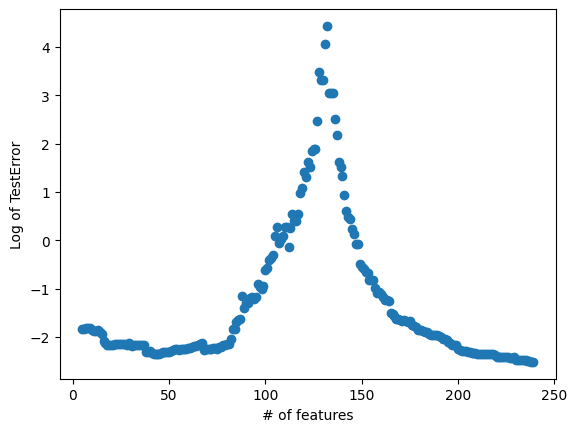

In [7]:
test_error_log_median = np.log(np.median(test_error,axis=0))
x_range = [range(5, 241)]

plt.scatter(x_range, test_error_log_median)
plt.ylabel("Log of TestError")
plt.xlabel("# of features")
plt.show()